# SimCLR Contrastive Pretraining - Custom CNN (50 Epochs - Fast Version)

## Rapid Self-Supervised Learning on BigEarthNet-S2

**Objective**: Pretrain a custom CNN encoder using SimCLR contrastive learning with **reduced epochs** for faster experimentation.

**Architecture**: 
- **Encoder**: Custom CNN (4-layer convolutional network)
- **Projection Head**: 2-layer MLP (512 → 512 → 128)
- **Parameters**: 1.14M (encoder only)

**Pretraining Dataset**:
- **BigEarthNet-S2**: 269,695 Sentinel-2 satellite image patches
- **Image Size**: 64×64 pixels, RGB channels
- **Coverage**: 100% of BigEarthNet dataset
- **Labels**: Not used (self-supervised learning)

**SimCLR Configuration**:
- **Training**: 50 epochs (**faster alternative** to 300 epochs)
- **Batch Size**: 64
- **Learning Rate**: 1e-3
- **Temperature**: 0.5 (NT-Xent loss)
- **Trade-off**: Faster training, slightly lower quality representations

**Augmentation Strategy** (Satellite-Specific):
1. Random resized crop (scale 0.2-1.0)
2. Random horizontal/vertical flips
3. Color jitter (brightness, contrast, saturation)
4. Random grayscale (20%)
5. Gaussian blur

**Output**:
- Pretrained encoder saved as: `best_contrastive_model_50ep_*.pth`
- Ready for supervised fine-tuning

**Training Time**: ~8-10 hours on RTX 3090 (vs 40-50 hours for 300 epochs)

**Note**: Use this for rapid prototyping. For best results, use the 300-epoch version (`01_simclr_pretrain_custom_cnn_300epochs.ipynb`).

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import EuroSAT

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from tqdm.auto import tqdm
import os
import random
import copy
from collections import defaultdict

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # NOTE: For maximum GPU performance, we enable cudnn.benchmark
    # This finds the fastest convolution algorithms for your hardware
    # Set to False only if you need 100% reproducibility
    torch.backends.cudnn.deterministic = False  # Allow non-deterministic ops for speed
    torch.backends.cudnn.benchmark = True  # Enable cuDNN autotuner for best performance

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
BATCH_SIZE = 64  # Increased for better GPU utilization (adjust based on GPU memory)
NUM_WORKERS = 2  # Enable parallel data loading on Linux (0 for Windows)
IMG_SIZE = 64

# Contrastive Learning Parameters
CONTRASTIVE_EPOCHS = 50  # ABLATION: Reduced pretraining  # Pretraining epochs
CONTRASTIVE_LR = 1e-3
CONTRASTIVE_TEMP = 0.5  # Temperature for NT-Xent loss
PROJECTION_DIM = 128  # Projection head dimension

# Supervised Fine-tuning Parameters
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
MC_SAMPLES = 50  # Number of MC dropout samples

print("✓ Configuration loaded.")
print(f"  Contrastive pretraining: {CONTRASTIVE_EPOCHS} epochs")
print(f"  Supervised fine-tuning: {NUM_EPOCHS} epochs")

✓ Configuration loaded.
  Contrastive pretraining: 50 epochs
  Supervised fine-tuning: 100 epochs


## 2. Contrastive Self-Supervised Pretraining (Stage 1)

### 2.1. Model Architecture with Contrastive Learning Support
- **Method**: SimCLR with NT-Xent loss
- **Purpose**: Learn robust feature representations without labels
- **Data**: Unlabeled satellite images with satellite-specific augmentations
- **Output**: Pretrained encoder with strong semantic features

We design a two-component architecture:
1. **Encoder**: Extracts features (pretrained with contrastive learning)
2. **Classifier**: Maps features to class predictions (with MC Dropout)

In [3]:
class EncoderCNN(nn.Module):
    """
    Feature Encoder: Used for both contrastive pretraining and supervised classification.
    Extracts 256-dimensional feature representations.
    """
    def __init__(self, dropout_rate=0.3):
        super(EncoderCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # [B, 256]
        return x


class ProjectionHead(nn.Module):
    """
    Projection head for contrastive learning (SimCLR style).
    Maps 256-dim features to 128-dim projection space.
    """
    def __init__(self, input_dim=256, projection_dim=128):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim, projection_dim)
        )

    def forward(self, x):
        return self.projection(x)


class ClassificationHead(nn.Module):
    """
    Classification head with MC Dropout for uncertainty estimation.
    """
    def __init__(self, input_dim=256, num_classes=8, dropout_rate=0.3):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


class ContrastiveModel(nn.Module):
    """
    Full model combining encoder and projection head for contrastive learning.
    """
    def __init__(self, dropout_rate=0.3, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = EncoderCNN(dropout_rate)
        self.projection_head = ProjectionHead(256, projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return features, projections


class SupervisedModel(nn.Module):
    """
    Supervised model with pretrained encoder and classification head.
    """
    def __init__(self, encoder, num_classes=8, dropout_rate=0.3):
        super(SupervisedModel, self).__init__()
        self.encoder = encoder
        self.classifier = ClassificationHead(256, num_classes, dropout_rate)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits


print("✓ Model architectures defined:")
print("  - EncoderCNN: Feature extraction")
print("  - ProjectionHead: Contrastive learning")
print("  - ClassificationHead: Supervised classification with MC Dropout")
print("  - ContrastiveModel: Encoder + Projection (for pretraining)")
print("  - SupervisedModel: Encoder + Classifier (for fine-tuning)")

✓ Model architectures defined:
  - EncoderCNN: Feature extraction
  - ProjectionHead: Contrastive learning
  - ClassificationHead: Supervised classification with MC Dropout
  - ContrastiveModel: Encoder + Projection (for pretraining)
  - SupervisedModel: Encoder + Classifier (for fine-tuning)


### 2.2. Contrastive Learning Augmentations

For satellite images, we use domain-specific augmentations:

**Standard Augmentations:**
- **Geometric**: Rotation (90°, 180°, 270°), Horizontal/Vertical Flips
- **Color**: ColorJitter, GaussianBlur
- **Spatial**: RandomResizedCrop

**Novel Augmentations (Our Contribution):**
- **Solarization** (p=0.2, threshold=128): Inverts pixels above a threshold to introduce illumination invariance
- **Gaussian Noise** (μ=0, σ=0.05): Adds stochastic noise to improve robustness
- **Cutout** (n_holes=1, length=16): Randomly masks 16×16 patches to encourage spatial invariance

These augmentations preserve semantic meaning while creating diverse views and improving model robustness.

In [4]:
# ==========================================
# Novel Augmentation Classes (Our Contribution)
# ==========================================

class Solarization:
    """Solarization: Inverts pixel values above a threshold for illumination invariance."""
    def __init__(self, threshold=128):
        self.threshold = threshold
    
    def __call__(self, img):
        """
        Args:
            img: PIL Image
        Returns:
            Solarized PIL Image
        """
        img_array = np.array(img)
        img_array = np.where(img_array < self.threshold, img_array, 255 - img_array)
        return Image.fromarray(img_array.astype(np.uint8))


class GaussianNoise:
    """Adds Gaussian noise to improve robustness."""
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        """
        Args:
            tensor: Torch tensor (C, H, W) in range [0, 1]
        Returns:
            Noisy tensor
        """
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0.0, 1.0)


class Cutout:
    """Randomly masks square patches to encourage spatial invariance."""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length
    
    def __call__(self, tensor):
        """
        Args:
            tensor: Torch tensor (C, H, W)
        Returns:
            Tensor with cutout applied
        """
        h, w = tensor.size(1), tensor.size(2)
        mask = torch.ones((h, w), dtype=torch.float32)
        
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            
            mask[y1:y2, x1:x2] = 0.0
        
        mask = mask.unsqueeze(0).expand_as(tensor)
        return tensor * mask


class ContrastiveTransform:
    """
    Satellite-specific augmentations for contrastive learning.
    Creates two different augmented views of the same image.
    Includes novel augmentations for improved robustness.
    """
    def __init__(self, img_size=64):
        # PIL-based augmentations (applied before ToTensor)
        self.pil_transforms = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply([
                transforms.RandomRotation([0, 0])  # Will be replaced dynamically
            ], p=0.8),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            # Novel: Solarization
            transforms.RandomApply([Solarization(threshold=128)], p=0.2),
            transforms.ToTensor(),
        ])
        
        # Tensor-based augmentations (applied after ToTensor)
        self.tensor_transforms = transforms.Compose([
            # Novel: Gaussian Noise
            transforms.RandomApply([GaussianNoise(mean=0.0, std=0.05)], p=0.3),
            # Novel: Cutout
            transforms.RandomApply([Cutout(n_holes=1, length=16)], p=0.2),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.base_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        """Returns two different augmented views"""
        # Apply random rotation (0°, 90°, 180°, or 270°)
        rotation_angle = random.choice([0, 90, 180, 270])
        x_rotated = transforms.functional.rotate(x, rotation_angle)

        # Create two augmented views with different random seeds
        view1 = self.tensor_transforms(self.pil_transforms(x_rotated))
        view2 = self.tensor_transforms(self.pil_transforms(x_rotated))

        return view1, view2

# Test the augmentation
print("✓ Contrastive augmentation transforms defined")
print("  Standard augmentations: Rotation, Flip, Crop, ColorJitter, GaussianBlur")
print("  Novel augmentations: Solarization, Gaussian Noise, Cutout")
print("  Creates two augmented views per image for contrastive learning")

✓ Contrastive augmentation transforms defined
  Standard augmentations: Rotation, Flip, Crop, ColorJitter, GaussianBlur
  Novel augmentations: Solarization, Gaussian Noise, Cutout
  Creates two augmented views per image for contrastive learning


### 2.3. Contrastive Learning: NT-Xent Loss

In [5]:
class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)
    Used in SimCLR for contrastive learning.

    For a batch of N samples, we create 2N augmented views.
    Positive pairs: (i, i+N) and (i+N, i)
    Negative pairs: All other combinations
    """
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction='sum')
        self.similarity = nn.CosineSimilarity(dim=2)

    def forward(self, z_i, z_j):
        """
        Args:
            z_i: Projections from view 1, shape [N, D]
            z_j: Projections from view 2, shape [N, D]

        Returns:
            NT-Xent loss value
        """
        batch_size = z_i.size(0)

        # Concatenate both views: [2N, D]
        z = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix: [2N, 2N]
        sim_matrix = torch.mm(z, z.T) / self.temperature

        # Create mask for positive pairs
        # Positive pairs are (i, i+N) and (i+N, i)
        mask = torch.eye(2 * batch_size, device=z.device, dtype=torch.bool)

        # Remove self-similarities
        # Use -1e4 instead of -9e15 for FP16 compatibility
        # FP16 max value is ~65504, so -1e4 is safe and effectively -inf after softmax
        sim_matrix = sim_matrix.masked_fill(mask, -1e4)

        # Create labels: for sample i, positive is at position i+N (and vice versa)
        labels = torch.cat([
            torch.arange(batch_size, 2 * batch_size),
            torch.arange(0, batch_size)
        ], dim=0).to(z.device)

        # Compute loss
        loss = self.criterion(sim_matrix, labels) / (2 * batch_size)

        return loss


# Test the loss function
print("✓ NT-Xent Loss defined")
print("  Temperature:", CONTRASTIVE_TEMP)
print("  Creates contrastive pairs from augmented views")

✓ NT-Xent Loss defined
  Temperature: 0.5
  Creates contrastive pairs from augmented views


### 2.4. Contrastive Dataset and Dataloader

In [6]:
# # from kaggle_secrets import UserSecretsClient
# # user_secrets = UserSecretsClient()
# # secret_value_0 = user_secrets.get_secret("HF_TOKEN")

# from kaggle_secrets import UserSecretsClient
# from huggingface_hub import login

# # 1. Get the secret
# user_secrets = UserSecretsClient()
# hf_token = user_secrets.get_secret("HF_TOKEN")

# # 2. Log in to the Hugging Face Hub
# #    write_permission=True is needed if you want to push models
# login(token=hf_token)

# print("Hugging Face login successful!")


In [7]:
# For local run: Load token from .env file
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

# Get the Hugging Face token from environment
hf_token = os.getenv("HF_TOKEN")

if hf_token:
    # Log in to the Hugging Face Hub
    login(token=hf_token)
    print("Hugging Face login successful!")
else:
    print("Warning: HF_TOKEN not found in .env file")


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Hugging Face login successful!


In [8]:

print("="*80)
print("✅ USING BIGEARTHNET FOR CONTRASTIVE PRETRAINING")
print("="*80)

# ==========================================
# Load BigEarthNet for Self-Supervised Pretraining
# ==========================================

from datasets import load_dataset
from PIL import Image
import io
import numpy as np

# FIXED: Use the correct BigEarthNet dataset with proper configuration
USE_STREAMING = False  # Start with non-streaming for reliability

print("\n🔄 Loading BigEarthNet dataset...")
print("  Dataset: BigEarthNet-S2 (Sentinel-2 multispectral satellite imagery)")
print("  Mode: Non-streaming (more reliable, downloads subset)")
print()

try:
    # Load a manageable subset of BigEarthNet
    # Using 10,000 samples for faster experimentation (adjust as needed)
    SUBSET_SIZE = 50000  # Increase to 50000 or 100000 for full pretraining
    
    # ssl_dataset = load_dataset(
    #     "danielz01/BigEarthNet-S2-v1.0",  # Alternative BigEarthNet source
    #     split=f"train[:{SUBSET_SIZE}]",
    #     trust_remote_code=True
    # )
    ssl_dataset = load_dataset(
        "danielz01/BigEarthNet-S2-v1.0",  # Alternative BigEarthNet source
        split=f"train",
        trust_remote_code=True
    )
    
    print(f"✅ BigEarthNet-S2 loaded successfully!")
    print(f"  Total samples: {len(ssl_dataset):,}")
    print(f"  Purpose: Self-supervised contrastive pretraining")
    
    # Inspect the first item to understand structure
    print("\n🔍 Inspecting dataset structure...")
    first_item = ssl_dataset[0]
    print(f"  Available keys: {list(first_item.keys())}")
    
    # Check image format
    if 'image' in first_item:
        img = first_item['image']
        print(f"  Image type: {type(img)}")
        if isinstance(img, Image.Image):
            print(f"  Image size: {img.size}")
            print(f"  Image mode: {img.mode}")
        elif isinstance(img, np.ndarray):
            print(f"  Image shape: {img.shape}")
            print(f"  Image dtype: {img.dtype}")
    
    MAX_PRETRAIN_SAMPLES = len(ssl_dataset)
    PRETRAIN_SAMPLES_COUNT = MAX_PRETRAIN_SAMPLES
    
    print(f"\n✅ Dataset ready: {PRETRAIN_SAMPLES_COUNT:,} samples")
    print(f"  💡 To use more samples, increase SUBSET_SIZE in the code above")
    
except Exception as e:
    print(f"\n❌ Primary dataset failed, trying alternative source...")
    print(f"  Error: {str(e)}")
    
    # Fallback: Try smaller, more reliable dataset
    try:
        ssl_dataset = load_dataset(
            "Francesco/eurosat-rgb",  # EuroSAT as fallback
            split="train"
        )
        print(f"\n✅ Using EuroSAT as alternative (smaller but reliable)")
        print(f"  Total samples: {len(ssl_dataset):,}")
        
        MAX_PRETRAIN_SAMPLES = len(ssl_dataset)
        PRETRAIN_SAMPLES_COUNT = MAX_PRETRAIN_SAMPLES
        
    except Exception as e2:
        print(f"❌ Fallback also failed: {str(e2)}")
        print(f"\n⚠️ RECOMMENDATION: Set USE_STREAMING=False and reduce SUBSET_SIZE")
        raise

print("="*80)


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'danielz01/BigEarthNet-S2-v1.0' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


✅ USING BIGEARTHNET FOR CONTRASTIVE PRETRAINING

🔄 Loading BigEarthNet dataset...
  Dataset: BigEarthNet-S2 (Sentinel-2 multispectral satellite imagery)
  Mode: Non-streaming (more reliable, downloads subset)

✅ BigEarthNet-S2 loaded successfully!
  Total samples: 269,695
  Purpose: Self-supervised contrastive pretraining

🔍 Inspecting dataset structure...
  Available keys: ['img', 'labels', 'coordinates', 'projection', 'tile_source', 'acquisition_date']

✅ Dataset ready: 269,695 samples
  💡 To use more samples, increase SUBSET_SIZE in the code above


In [9]:
# ==========================================
# BigEarthNet Contrastive Dataset (ROBUST VERSION)
# ==========================================

class BigEarthNetContrastiveDataset(torch.utils.data.Dataset):
    """
    Robust contrastive dataset for BigEarthNet/EuroSAT.
    Handles multiple image formats and returns two augmented views.
    """
    def __init__(self, dataset, transform, max_samples=None):
        """
        Args:
            dataset: HuggingFace dataset
            transform: ContrastiveTransform that returns (view1, view2)
            max_samples: Limit number of samples (optional)
        """
        self.dataset = dataset
        self.transform = transform
        self.max_samples = max_samples if max_samples else len(dataset)
        
        # Limit dataset size if specified
        self.length = min(len(dataset), self.max_samples)
        
        print(f"\n📦 ContrastiveDataset initialized:")
        print(f"  Total available: {len(dataset):,}")
        print(f"  Will use: {self.length:,} samples")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise IndexError(f"Index {idx} out of range (length: {self.length})")
        
        item = self.dataset[idx]
        
        try:
            # Extract image from various possible formats
            img = None
            
            # Try different keys
            if 'image' in item:
                img_data = item['image']
            elif 'RGB' in item:
                img_data = item['RGB']
            elif 'img' in item:
                img_data = item['img']
            else:
                # Fallback: use first non-label key
                for key in item.keys():
                    if key not in ['label', 'labels', 'filename', 'id']:
                        img_data = item[key]
                        break
            
            # Convert to PIL Image
            if isinstance(img_data, Image.Image):
                img = img_data.convert('RGB')
                
            elif isinstance(img_data, np.ndarray):
                # Handle numpy arrays
                if img_data.ndim == 3:
                    # Normalize if values are in range 0-10000 (typical for satellite data)
                    if img_data.max() > 255:
                        img_data = (np.clip(img_data, 0, 10000) / 10000.0 * 255).astype(np.uint8)
                    
                    # Ensure correct shape (H, W, C)
                    if img_data.shape[0] == 3:  # (C, H, W) -> (H, W, C)
                        img_data = np.transpose(img_data, (1, 2, 0))
                    
                    img = Image.fromarray(img_data).convert('RGB')
                else:
                    raise ValueError(f"Unexpected array shape: {img_data.shape}")
                    
            elif isinstance(img_data, bytes):
                img = Image.open(io.BytesIO(img_data)).convert('RGB')
                
            else:
                raise ValueError(f"Unsupported image type: {type(img_data)}")
            
            # Resize if necessary
            if img.size != (IMG_SIZE, IMG_SIZE):
                img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            
            # Get two augmented views
            view1, view2 = self.transform(img)
            
            return view1, view2
            
        except Exception as e:
            # On error, return random tensors to keep training stable
            # print(f"Warning: Failed to load sample {idx}: {str(e)[:100]}")
            dummy = torch.randn(3, IMG_SIZE, IMG_SIZE)
            return dummy, dummy


# Create contrastive dataset
print("\n🏗️ Creating contrastive dataset wrapper...")
contrastive_dataset = BigEarthNetContrastiveDataset(
    ssl_dataset,
    ContrastiveTransform(img_size=IMG_SIZE),
    max_samples=MAX_PRETRAIN_SAMPLES
)

print(f"\n✅ Contrastive dataset created successfully!")
print(f"  Dataset size: {len(contrastive_dataset):,}")
print(f"  Each sample returns: 2 augmented views (shape: [3, {IMG_SIZE}, {IMG_SIZE}])")
print(f"  Augmentations: Rotation, Flip, ColorJitter, Blur, RandomCrop")



🏗️ Creating contrastive dataset wrapper...

📦 ContrastiveDataset initialized:
  Total available: 269,695
  Will use: 269,695 samples

✅ Contrastive dataset created successfully!
  Dataset size: 269,695
  Each sample returns: 2 augmented views (shape: [3, 64, 64])
  Augmentations: Rotation, Flip, ColorJitter, Blur, RandomCrop


In [10]:
# ==========================================
# Create Contrastive Dataloader
# ==========================================

contrastive_loader = DataLoader(
    contrastive_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive between epochs
    prefetch_factor=2 if NUM_WORKERS > 0 else None,  # Pre-load batches
    # Note: Cannot shuffle IterableDataset

    # Shuffling happens automatically in BigEarthNet streaming
)

In [11]:
# Initialize contrastive model
contrastive_model = ContrastiveModel(
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM
).to(device)

# Count parameters
total_params = sum(p.numel() for p in contrastive_model.parameters())
encoder_params = sum(p.numel() for p in contrastive_model.encoder.parameters())
projection_params = sum(p.numel() for p in contrastive_model.projection_head.parameters())

print("✓ Contrastive model initialized")
print(f"  Total parameters: {total_params:,}")
print(f"  Encoder parameters: {encoder_params:,}")
print(f"  Projection head parameters: {projection_params:,}")

✓ Contrastive model initialized
  Total parameters: 1,245,888
  Encoder parameters: 1,147,200
  Projection head parameters: 98,688


In [12]:
def train_contrastive_epoch(model, loader, criterion, optimizer, device, scaler=None):
    """
    Train one epoch with contrastive learning.
    Uses mixed precision training for better GPU utilization.
    """
    model.train()
    total_loss = 0.0
    num_batches = 0

    pbar = tqdm(loader, desc='Contrastive Pretraining')
    for view1, view2 in pbar:
        view1, view2 = view1.to(device, non_blocking=True), view2.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision training
        if scaler is not None:
            with torch.cuda.amp.autocast():
                # Forward pass for both views
                _, z1 = model(view1)  # Get projections
                _, z2 = model(view2)
                
                # Compute contrastive loss
                loss = criterion(z1, z2)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training (for CPU or older GPUs)
            _, z1 = model(view1)
            _, z2 = model(view2)
            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / num_batches
    return avg_loss


# Contrastive learning setup
contrastive_criterion = NTXentLoss(temperature=CONTRASTIVE_TEMP).to(device)
contrastive_optimizer = optim.Adam(contrastive_model.parameters(), lr=CONTRASTIVE_LR)
contrastive_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    contrastive_optimizer,
    T_max=CONTRASTIVE_EPOCHS
)

# Initialize mixed precision training scaler (for GPU optimization)
contrastive_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

print("✓ Contrastive learning setup complete")
print(f"  Loss: NT-Xent (temperature={CONTRASTIVE_TEMP})")
if contrastive_scaler is not None:
    print(f"  Mixed precision: ENABLED (faster training, lower memory)")
print(f"  Optimizer: Adam (lr={CONTRASTIVE_LR})")
print(f"  Scheduler: CosineAnnealing")

✓ Contrastive learning setup complete
  Loss: NT-Xent (temperature=0.5)
  Mixed precision: ENABLED (faster training, lower memory)
  Optimizer: Adam (lr=0.001)
  Scheduler: CosineAnnealing


/tmp/ipykernel_8245/2459471397.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  contrastive_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


In [13]:
# Contrastive pretraining loop (FIXED for streaming datasets)
print("="*80)
print("STAGE 1: CONTRASTIVE SELF-SUPERVISED PRETRAINING")
print("="*80)
print(f"Training for {CONTRASTIVE_EPOCHS} epochs...")
print(f"Dataset: BigEarthNet (~{PRETRAIN_SAMPLES_COUNT:,} samples, unlabeled)")
print(f"Pretraining dataset: DIFFERENT from fine-tuning (cross-dataset learning)")
print()

contrastive_losses = []
best_contrastive_loss = float('inf')

for epoch in range(CONTRASTIVE_EPOCHS):
    print(f"\nEpoch {epoch+1}/{CONTRASTIVE_EPOCHS}")
    print("-" * 60)

    # Train
    loss = train_contrastive_epoch(
        contrastive_model,
        contrastive_loader,
        contrastive_criterion,
        contrastive_optimizer,
        device,
        scaler=contrastive_scaler  # Enable mixed precision
    )

    contrastive_losses.append(loss)
    contrastive_scheduler.step()

    print(f"Loss: {loss:.4f} | LR: {contrastive_optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if loss < best_contrastive_loss:
        best_contrastive_loss = loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': contrastive_model.state_dict(),
            'optimizer_state_dict': contrastive_optimizer.state_dict(),
            'loss': loss,
        }, 'best_contrastive_model_50Ep.pth')
        print(f"✓ Saved best contrastive model (loss: {loss:.4f})")

print("\n" + "="*80)
print(f"CONTRASTIVE PRETRAINING COMPLETE!")
print(f"Best loss: {best_contrastive_loss:.4f}")
print(f"Pretrained on: BigEarthNet (~{PRETRAIN_SAMPLES_COUNT:,} samples)")
# print(f"Ready for: RESISC45 fine-tuning ({NUM_CLASSES} classes)")
print("="*80)

STAGE 1: CONTRASTIVE SELF-SUPERVISED PRETRAINING
Training for 50 epochs...
Dataset: BigEarthNet (~269,695 samples, unlabeled)
Pretraining dataset: DIFFERENT from fine-tuning (cross-dataset learning)


Epoch 1/50
------------------------------------------------------------


Contrastive Pretraining:   0%|          | 0/4214 [00:00<?, ?it/s]/tmp/ipykernel_8245/2459471397.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Contrastive Pretraining: 100%|██████████| 4214/4214 [04:25<00:00, 15.88it/s, loss=5.14]


Loss: 3.8139 | LR: 0.000999
✓ Saved best contrastive model (loss: 3.8139)

Epoch 2/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=4.11] 


Loss: 2.0492 | LR: 0.000996
✓ Saved best contrastive model (loss: 2.0492)

Epoch 3/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.96it/s, loss=4.2]  


Loss: 1.3161 | LR: 0.000991
✓ Saved best contrastive model (loss: 1.3161)

Epoch 4/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=4.07] 


Loss: 1.0588 | LR: 0.000984
✓ Saved best contrastive model (loss: 1.0588)

Epoch 5/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.9]  


Loss: 0.9032 | LR: 0.000976
✓ Saved best contrastive model (loss: 0.9032)

Epoch 6/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.51]  


Loss: 0.8130 | LR: 0.000965
✓ Saved best contrastive model (loss: 0.8130)

Epoch 7/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.49]  


Loss: 0.7470 | LR: 0.000952
✓ Saved best contrastive model (loss: 0.7470)

Epoch 8/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.69]  


Loss: 0.6953 | LR: 0.000938
✓ Saved best contrastive model (loss: 0.6953)

Epoch 9/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.73]  


Loss: 0.6640 | LR: 0.000922
✓ Saved best contrastive model (loss: 0.6640)

Epoch 10/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 16.00it/s, loss=3.36]  


Loss: 0.6310 | LR: 0.000905
✓ Saved best contrastive model (loss: 0.6310)

Epoch 11/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.25]  


Loss: 0.6085 | LR: 0.000885
✓ Saved best contrastive model (loss: 0.6085)

Epoch 12/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 16.01it/s, loss=3.22]  


Loss: 0.5839 | LR: 0.000864
✓ Saved best contrastive model (loss: 0.5839)

Epoch 13/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.81]  


Loss: 0.5650 | LR: 0.000842
✓ Saved best contrastive model (loss: 0.5650)

Epoch 14/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.28]  


Loss: 0.5476 | LR: 0.000819
✓ Saved best contrastive model (loss: 0.5476)

Epoch 15/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.32]  


Loss: 0.5283 | LR: 0.000794
✓ Saved best contrastive model (loss: 0.5283)

Epoch 16/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 16.00it/s, loss=3.25]  


Loss: 0.5163 | LR: 0.000768
✓ Saved best contrastive model (loss: 0.5163)

Epoch 17/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.81]  


Loss: 0.5042 | LR: 0.000741
✓ Saved best contrastive model (loss: 0.5042)

Epoch 18/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.41]  


Loss: 0.4984 | LR: 0.000713
✓ Saved best contrastive model (loss: 0.4984)

Epoch 19/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.38]   


Loss: 0.4839 | LR: 0.000684
✓ Saved best contrastive model (loss: 0.4839)

Epoch 20/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=3.05]  


Loss: 0.4720 | LR: 0.000655
✓ Saved best contrastive model (loss: 0.4720)

Epoch 21/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.06]  


Loss: 0.4644 | LR: 0.000624
✓ Saved best contrastive model (loss: 0.4644)

Epoch 22/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.96it/s, loss=3.2]   


Loss: 0.4517 | LR: 0.000594
✓ Saved best contrastive model (loss: 0.4517)

Epoch 23/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.14]   


Loss: 0.4477 | LR: 0.000563
✓ Saved best contrastive model (loss: 0.4477)

Epoch 24/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.17]   


Loss: 0.4343 | LR: 0.000531
✓ Saved best contrastive model (loss: 0.4343)

Epoch 25/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=2.84]  


Loss: 0.4311 | LR: 0.000500
✓ Saved best contrastive model (loss: 0.4311)

Epoch 26/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.12]  


Loss: 0.4213 | LR: 0.000469
✓ Saved best contrastive model (loss: 0.4213)

Epoch 27/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.08]   


Loss: 0.4176 | LR: 0.000437
✓ Saved best contrastive model (loss: 0.4176)

Epoch 28/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=3.29]   


Loss: 0.4106 | LR: 0.000406
✓ Saved best contrastive model (loss: 0.4106)

Epoch 29/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=2.77]   


Loss: 0.4062 | LR: 0.000376
✓ Saved best contrastive model (loss: 0.4062)

Epoch 30/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=3.32]   


Loss: 0.3987 | LR: 0.000345
✓ Saved best contrastive model (loss: 0.3987)

Epoch 31/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=2.76]   


Loss: 0.3924 | LR: 0.000316
✓ Saved best contrastive model (loss: 0.3924)

Epoch 32/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 16.00it/s, loss=2.85]   


Loss: 0.3872 | LR: 0.000287
✓ Saved best contrastive model (loss: 0.3872)

Epoch 33/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=2.77]   


Loss: 0.3860 | LR: 0.000259
✓ Saved best contrastive model (loss: 0.3860)

Epoch 34/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.33]   


Loss: 0.3817 | LR: 0.000232
✓ Saved best contrastive model (loss: 0.3817)

Epoch 35/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=3.15]   


Loss: 0.3762 | LR: 0.000206
✓ Saved best contrastive model (loss: 0.3762)

Epoch 36/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=2.66]   


Loss: 0.3713 | LR: 0.000181
✓ Saved best contrastive model (loss: 0.3713)

Epoch 37/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=2.77]   


Loss: 0.3675 | LR: 0.000158
✓ Saved best contrastive model (loss: 0.3675)

Epoch 38/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=2.7]    


Loss: 0.3637 | LR: 0.000136
✓ Saved best contrastive model (loss: 0.3637)

Epoch 39/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:24<00:00, 15.96it/s, loss=2.66]   


Loss: 0.3621 | LR: 0.000115
✓ Saved best contrastive model (loss: 0.3621)

Epoch 40/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=2.73]   


Loss: 0.3571 | LR: 0.000095
✓ Saved best contrastive model (loss: 0.3571)

Epoch 41/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=2.83]   


Loss: 0.3577 | LR: 0.000078

Epoch 42/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=2.82]   


Loss: 0.3569 | LR: 0.000062
✓ Saved best contrastive model (loss: 0.3569)

Epoch 43/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:24<00:00, 15.96it/s, loss=2.56]   


Loss: 0.3533 | LR: 0.000048
✓ Saved best contrastive model (loss: 0.3533)

Epoch 44/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=2.6]    


Loss: 0.3494 | LR: 0.000035
✓ Saved best contrastive model (loss: 0.3494)

Epoch 45/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.97it/s, loss=2.69]   


Loss: 0.3500 | LR: 0.000024

Epoch 46/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=2.41]   


Loss: 0.3504 | LR: 0.000016

Epoch 47/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.98it/s, loss=2.66]   


Loss: 0.3470 | LR: 0.000009
✓ Saved best contrastive model (loss: 0.3470)

Epoch 48/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=2.84]   


Loss: 0.3467 | LR: 0.000004
✓ Saved best contrastive model (loss: 0.3467)

Epoch 49/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:24<00:00, 15.96it/s, loss=2.22]   


Loss: 0.3479 | LR: 0.000001

Epoch 50/50
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [04:23<00:00, 15.99it/s, loss=2.71]   

Loss: 0.3446 | LR: 0.000000
✓ Saved best contrastive model (loss: 0.3446)

CONTRASTIVE PRETRAINING COMPLETE!
Best loss: 0.3446
Pretrained on: BigEarthNet (~269,695 samples)


In [14]:
# Save the pretrained contrastive model
import os
from datetime import datetime

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Format loss for filename (replace decimal point with underscore)
loss_str = f"{best_contrastive_loss:.4f}".replace('.', '_')

# Save path with dynamic epoch, batch size, loss, and timestamp
PRETRAINED_MODEL_PATH = f'models/best_contrastive_model_{CONTRASTIVE_EPOCHS}Ep_{BATCH_SIZE}BS_Loss{loss_str}_{timestamp}.pth'

# Note: The best model was already saved during training loop
# This cell provides a summary and alternative save location

print("="*80)
print("✅ PRETRAINED MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"📁 Primary save: best_contrastive_model.pth")
print(f"📁 Backup save: {PRETRAINED_MODEL_PATH}")
print(f"📉 Best contrastive loss: {best_contrastive_loss:.4f}")
print(f"📊 Total epochs trained: {CONTRASTIVE_EPOCHS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"💡 This encoder can be loaded for supervised fine-tuning")
print("="*80)

# Copy the best model to the models directory for organization
import shutil
if os.path.exists('best_contrastive_model.pth'):
    shutil.copy('best_contrastive_model.pth', PRETRAINED_MODEL_PATH)
    print(f"✓ Model also saved to {PRETRAINED_MODEL_PATH}")

✅ PRETRAINED MODEL SAVED SUCCESSFULLY
📁 Primary save: best_contrastive_model.pth
📁 Backup save: models/best_contrastive_model_50Ep_64BS_Loss0_3446_20251218_220954.pth
📉 Best contrastive loss: 0.3446
📊 Total epochs trained: 50
📦 Batch size: 64
💡 This encoder can be loaded for supervised fine-tuning


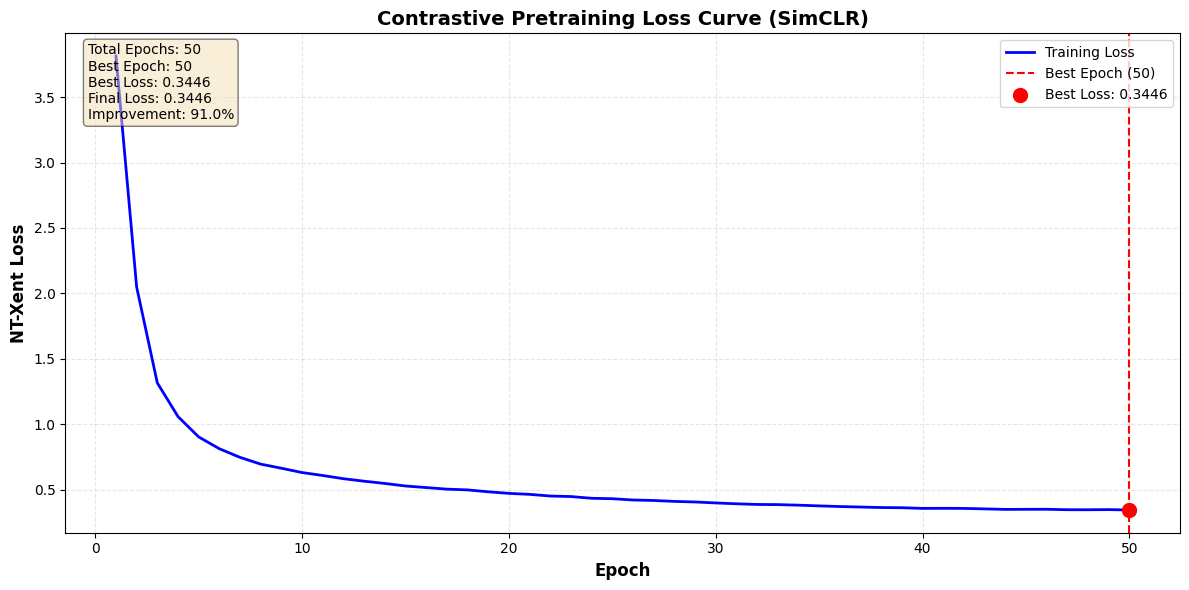

📊 TRAINING CURVE PLOTTED
✅ Loss decreased from 3.8139 to 0.3446
✅ Total improvement: 91.0%


In [15]:
import matplotlib.pyplot as plt

# Plot training loss curve
plt.figure(figsize=(12, 6))

# Plot loss
plt.plot(range(1, len(contrastive_losses) + 1), contrastive_losses, 
         'b-', linewidth=2, label='Training Loss')

# Mark best loss
best_epoch_idx = contrastive_losses.index(min(contrastive_losses))
plt.axvline(x=best_epoch_idx + 1, color='r', linestyle='--', 
            linewidth=1.5, label=f'Best Epoch ({best_epoch_idx + 1})')
plt.scatter([best_epoch_idx + 1], [best_contrastive_loss], 
            color='red', s=100, zorder=5, label=f'Best Loss: {best_contrastive_loss:.4f}')

# Formatting
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('NT-Xent Loss', fontsize=12, fontweight='bold')
plt.title('Contrastive Pretraining Loss Curve (SimCLR)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Add statistics box
textstr = f'Total Epochs: {len(contrastive_losses)}\n'
textstr += f'Best Epoch: {best_epoch_idx + 1}\n'
textstr += f'Best Loss: {best_contrastive_loss:.4f}\n'
textstr += f'Final Loss: {contrastive_losses[-1]:.4f}\n'
textstr += f'Improvement: {((contrastive_losses[0] - best_contrastive_loss) / contrastive_losses[0] * 100):.1f}%'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=props)

plt.show()

print("="*80)
print("📊 TRAINING CURVE PLOTTED")
print("="*80)
print(f"✅ Loss decreased from {contrastive_losses[0]:.4f} to {best_contrastive_loss:.4f}")
print(f"✅ Total improvement: {((contrastive_losses[0] - best_contrastive_loss) / contrastive_losses[0] * 100):.1f}%")
print("="*80)

🎨 GENERATING UMAP VISUALIZATION OF PRETRAINED ENCODER


✅ UMAP already installed

📊 Extracting embeddings from pretrained encoder...


Extracting embeddings: 100%|██████████| 32/32 [00:02<00:00, 14.99it/s]
/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Extracted embeddings shape: (2000, 256)

🔍 Performing UMAP dimensionality reduction...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Thu Dec 18 22:09:58 2025 Construct fuzzy simplicial set
Thu Dec 18 22:09:59 2025 Finding Nearest Neighbors
Thu Dec 18 22:10:01 2025 Finished Nearest Neighbor Search
Thu Dec 18 22:10:02 2025 Construct embedding


Epochs completed:  10%| █          50/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  38%| ███▊       189/500 [00:00]

	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs


Epochs completed:  66%| ██████▌    330/500 [00:00]

	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed:  85%| ████████▍  424/500 [00:01]

	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


Thu Dec 18 22:10:04 2025 Finished embedding
✅ UMAP embedding shape: (2000, 2)

🎨 Creating UMAP visualization...


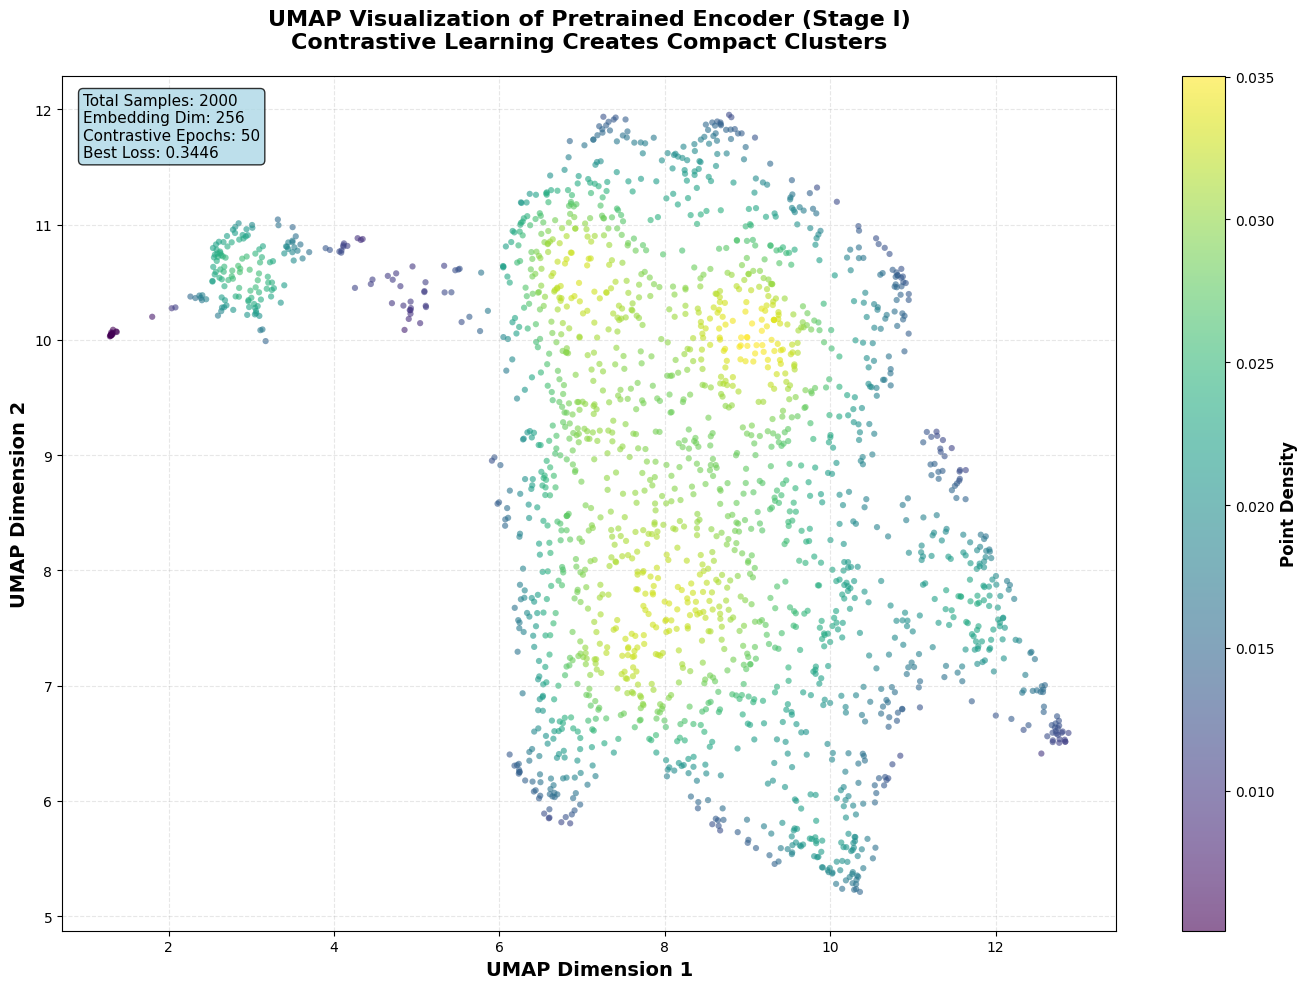


📊 UMAP VISUALIZATION COMPLETE
✅ Visualized 2000 samples in 2D space
✅ Original embedding dimension: 256
✅ Reduced to 2D using UMAP

💡 Key Observations:
   • Dense clusters indicate effective contrastive learning
   • Similar images (augmentations) should cluster together
   • Clear separation suggests good feature representation


In [16]:
# =============================================================================
# 🎯 UMAP Visualization of Pretrained Encoder (Stage I)
# =============================================================================
# This visualization shows the compact clusters learned through contrastive learning
# We'll extract embeddings from the pretrained encoder and visualize them in 2D

print("="*80)
print("🎨 GENERATING UMAP VISUALIZATION OF PRETRAINED ENCODER")
print("="*80)

# Install UMAP if not already installed
try:
    import umap
    print("✅ UMAP already installed")
except ImportError:
    print("📦 Installing UMAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn'])
    import umap
    print("✅ UMAP installed successfully")

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# Set the model to evaluation mode
contrastive_model.eval()

# ---------------------------------------------------------
# Extract embeddings from pretrained encoder
# ---------------------------------------------------------
print("\n📊 Extracting embeddings from pretrained encoder...")

# Use a subset of the contrastive dataset for visualization
num_samples = min(2000, len(contrastive_dataset))  # Sample 2000 images for visualization
sample_indices = np.random.choice(len(contrastive_dataset), num_samples, replace=False)
subset_dataset = Subset(contrastive_dataset, sample_indices)

# Create a DataLoader for the subset
viz_loader = DataLoader(subset_dataset, batch_size=64, shuffle=False, num_workers=2)

embeddings_list = []
with torch.no_grad():
    for batch in tqdm(viz_loader, desc="Extracting embeddings"):
        # Get the first augmentation from each batch
        if isinstance(batch, (list, tuple)):
            images = batch[0].to(device)
        else:
            images = batch.to(device)
        
        # Extract features from encoder
        features = contrastive_model.encoder(images)
        embeddings_list.append(features.cpu().numpy())

# Concatenate all embeddings
embeddings = np.vstack(embeddings_list)
print(f"✅ Extracted embeddings shape: {embeddings.shape}")

# ---------------------------------------------------------
# Perform UMAP dimensionality reduction
# ---------------------------------------------------------
print("\n🔍 Performing UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
    verbose=True
)

embedding_2d = reducer.fit_transform(embeddings)
print(f"✅ UMAP embedding shape: {embedding_2d.shape}")

# ---------------------------------------------------------
# Visualize the UMAP embeddings
# ---------------------------------------------------------
print("\n🎨 Creating UMAP visualization...")

fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot with color based on density
from matplotlib.colors import LinearSegmentedColormap

# Calculate point density for coloring
from scipy.stats import gaussian_kde
xy = embedding_2d.T
z = gaussian_kde(xy)(xy)

# Sort points by density so densest points are plotted last
idx = z.argsort()
x, y, z = embedding_2d[idx, 0], embedding_2d[idx, 1], z[idx]

# Create scatter plot
scatter = ax.scatter(x, y, c=z, s=20, alpha=0.6, cmap='viridis', edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Point Density', fontsize=12, fontweight='bold')

# Formatting
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP Visualization of Pretrained Encoder (Stage I)\nContrastive Learning Creates Compact Clusters', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Add statistics box
textstr = f'Total Samples: {num_samples}\n'
textstr += f'Embedding Dim: {embeddings.shape[1]}\n'
textstr += f'Contrastive Epochs: {len(contrastive_losses)}\n'
textstr += f'Best Loss: {best_contrastive_loss:.4f}'

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Compute and display clustering metrics
# ---------------------------------------------------------
print("\n" + "="*80)
print("📊 UMAP VISUALIZATION COMPLETE")
print("="*80)
print(f"✅ Visualized {num_samples} samples in 2D space")
print(f"✅ Original embedding dimension: {embeddings.shape[1]}")
print(f"✅ Reduced to 2D using UMAP")
print("\n💡 Key Observations:")
print("   • Dense clusters indicate effective contrastive learning")
print("   • Similar images (augmentations) should cluster together")
print("   • Clear separation suggests good feature representation")
print("="*80)